In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl

FONTSIZE = 16
plt.rcParams.update({'font.size': FONTSIZE})

def get_common_configs():
    color_scheme = {128: "#1f77b4", 1024: "#2ca02c", 8192: "#ff7f0e", 64: "#1f77b4", 288: "#ff7f0e"}
    marker_scheme = {128: "o", 1024: "v", 8192: "s", 64: "o", 288: "s"}
    linestyle_scheme = {"Vanilla NN": "-", "GNN": ":", "Data-Driven NN": "-"}
    return color_scheme, marker_scheme, linestyle_scheme

def make_legends(linestyle_scheme, color_scheme, marker_scheme):
    arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
                  for arch in linestyle_scheme.keys()]
    sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                                linestyle='none', label=f'{size}', markersize=8)
                     for size in color_scheme.keys()]
    return arch_lines, sample_patches

def setup_results_interpreter():
    results_interpretor = rri.RayResultsinterpreter()
    def custom_data_filler(out_row, reference_row): out_row['path'] = reference_row['path']
    def default_condition_setter(condition_name): return None
    return results_interpretor, custom_data_filler, default_condition_setter

# --- Data Parse Functions ---

def parse_serial_system():
    testset_name = "finals_serial"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
        "GNN": lambda: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = ["serial_system_3", "serial_system_4", "serial_system_5", "serial_system_6", "serial_system_7"]
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path_fn in architectures.items():
        path = path_fn()
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'store_lead_time': [4],
             'samples': [1],
             'config': configs},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['system_length'] = df['config'].apply(lambda c: int(str(c).split('_')[-1]))
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    results = []
    for system_length in [int(config.split('_')[-1]) for config in configs]:
        for sample_size in sample_sizes:
            vanilla_rows = df[
                (df['system_length'] == system_length) &
                (df['train_dev_sample_and_batch_size'] == sample_size) &
                (df['Architecture Class'] == "Vanilla NN")
            ]
            gnn_rows = df[
                (df['system_length'] == system_length) &
                (df['train_dev_sample_and_batch_size'] == sample_size) &
                (df['Architecture Class'] == "GNN")
            ]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = (vanilla_loss - gnn_loss) / vanilla_loss * 100
            results.append({
                'setting': 'serial_system',
                'sample_size': sample_size,
                'system_length': system_length,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "system_length",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "configs": configs
        }
    }

def parse_one_warehouse():
    testset_name = "finals_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse',
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path_fn in architectures.items():
        path = path_fn(None)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'store_lead_time': [[2, 6]],
             'samples': [1],
             'n_stores': n_stores},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['n_stores'].astype(int)
    results = []
    for sample_size in sample_sizes:
        for n_store in n_stores:
            vanilla_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Vanilla NN")]
            gnn_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = (vanilla_loss - gnn_loss) / vanilla_loss * 100
            results.append({
                'setting': 'one_warehouse',
                'sample_size': sample_size,
                'n_stores': n_store,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "n_stores_list": n_stores
        }
    }

def parse_transshipment():
    testset_name = "finals_transshipment"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment',
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    lower_bounds = {
        3: 8.533673716946652,
        5: 7.902133198919353,
        10: 8.296968310182638,
        20: 8.731082080524004,
        30: 8.37732777290095,
        50: 8.118102268777966,
    }
    dfs = []
    for arch_name, path_fn in architectures.items():
        path = path_fn(None)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'store_lead_time': [4],
             'samples': [1],
             'n_stores': n_stores},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['n_stores'].astype(int)
    results = []
    for sample_size in sample_sizes:
        for n_store in n_stores:
            vanilla_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Vanilla NN")]
            gnn_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = (vanilla_loss - gnn_loss) / vanilla_loss * 100
            results.append({
                'setting': 'transshipment',
                'sample_size': sample_size,
                'n_stores': n_store,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "n_stores_list": n_stores
        }
    }

def parse_real_one_warehouse():
    testset_name = "finals_real_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    }
    store_counts = [3, 5, 10, 15, 21]
    sample_sizes = [64, 288]
    dfs = []
    for arch_name, path in architectures.items():
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'n_stores': store_counts,
             'test_n_samples': sample_sizes},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['n_stores'].astype(int)
    results = []
    for sample_size in sample_sizes:
        for n_stores in store_counts:
            vanilla_rows = df[(df['n_stores'] == n_stores) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Data-Driven NN")]
            gnn_rows = df[(df['n_stores'] == n_stores) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = -(vanilla_loss - gnn_loss) / vanilla_loss * 100
            results.append({
                'setting': 'real_one_warehouse',
                'sample_size': sample_size,
                'n_stores': n_stores,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "n_stores_list": store_counts
        }
    }

def parse_many_warehouses():
    testset_name = "finals_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_warehouses',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = [
        "n_warehouse_10_2_lost_demand",
        "n_warehouse_20_3_lost_demand",
        "n_warehouse_30_4_lost_demand", 
        "n_warehouse_40_5_lost_demand", 
        "n_warehouse_50_6_lost_demand"
    ]
    config_to_stores_warehouses = {
        "n_warehouse_10_2_lost_demand": (10, 2),
        "n_warehouse_20_3_lost_demand": (20, 3),
        "n_warehouse_30_4_lost_demand": (30, 4),
        "n_warehouse_40_5_lost_demand": (40, 5),
        "n_warehouse_50_6_lost_demand": (50, 6)
    }
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path in architectures.items():
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'config': configs,
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['config'].map(lambda c: config_to_stores_warehouses[c][0])
    df['n_warehouses'] = df['config'].map(lambda c: config_to_stores_warehouses[c][1])
    results = []
    for sample_size in sample_sizes:
        for config in configs:
            vanilla_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Vanilla NN")]
            gnn_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = (vanilla_loss - gnn_loss) / vanilla_loss * 100
            results.append({
                'setting': 'many_warehouses',
                'sample_size': sample_size,
                'config': config,
                'n_stores': config_to_stores_warehouses[config][0],
                'n_warehouses': config_to_stores_warehouses[config][1],
                'improvement_percentage': improvement
            })
    x_ticks = [10, 20, 30, 40, 50]
    x_tick_labels = []
    for n_stores in x_ticks:
        for config, (stores, warehouses) in config_to_stores_warehouses.items():
            if stores == n_stores:
                x_tick_labels.append(f"({stores},{warehouses})")
                break
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "configs": configs,
            "x_ticks": x_ticks,
            "x_tick_labels": x_tick_labels
        }
    }

def parse_real_many_warehouses():
    testset_name = "finals_real_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_n_warehouses_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    }
    configs = [
        "n_warehouse_21_2_real_lost_demand",
        "n_warehouse_21_3_real_lost_demand",
        "n_warehouse_21_4_real_lost_demand",
        "n_warehouse_21_5_real_lost_demand"
    ]
    config_to_warehouses = {
        "n_warehouse_21_2_real_lost_demand": 2,
        "n_warehouse_21_3_real_lost_demand": 3,
        "n_warehouse_21_4_real_lost_demand": 4,
        "n_warehouse_21_5_real_lost_demand": 5
    }
    sample_sizes = [64, 288]
    dfs = []
    for arch_name, path in architectures.items():
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'config': configs,
             'test_n_samples': sample_sizes},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_warehouses'] = df['config'].map(lambda c: config_to_warehouses[c])
    results = []
    for sample_size in sample_sizes:
        for config in configs:
            vanilla_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Data-Driven NN")]
            gnn_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = -(vanilla_loss - gnn_loss) / vanilla_loss * 100
            results.append({
                'setting': 'real_many_warehouses',
                'sample_size': sample_size,
                'config': config,
                'n_warehouses': config_to_warehouses[config],
                'improvement_percentage': improvement
            })
    x_ticks = sorted(list(config_to_warehouses.values()))
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_warehouses",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "configs": configs,
            "x_ticks": x_ticks
        }
    }

# --- Data Loading ---
serial_system_data = parse_serial_system()
one_warehouse_data = parse_one_warehouse()
real_one_warehouse_data = parse_real_one_warehouse()
transshipment_data = parse_transshipment()
many_warehouses_data = parse_many_warehouses()
real_many_warehouses_data = parse_real_many_warehouses()

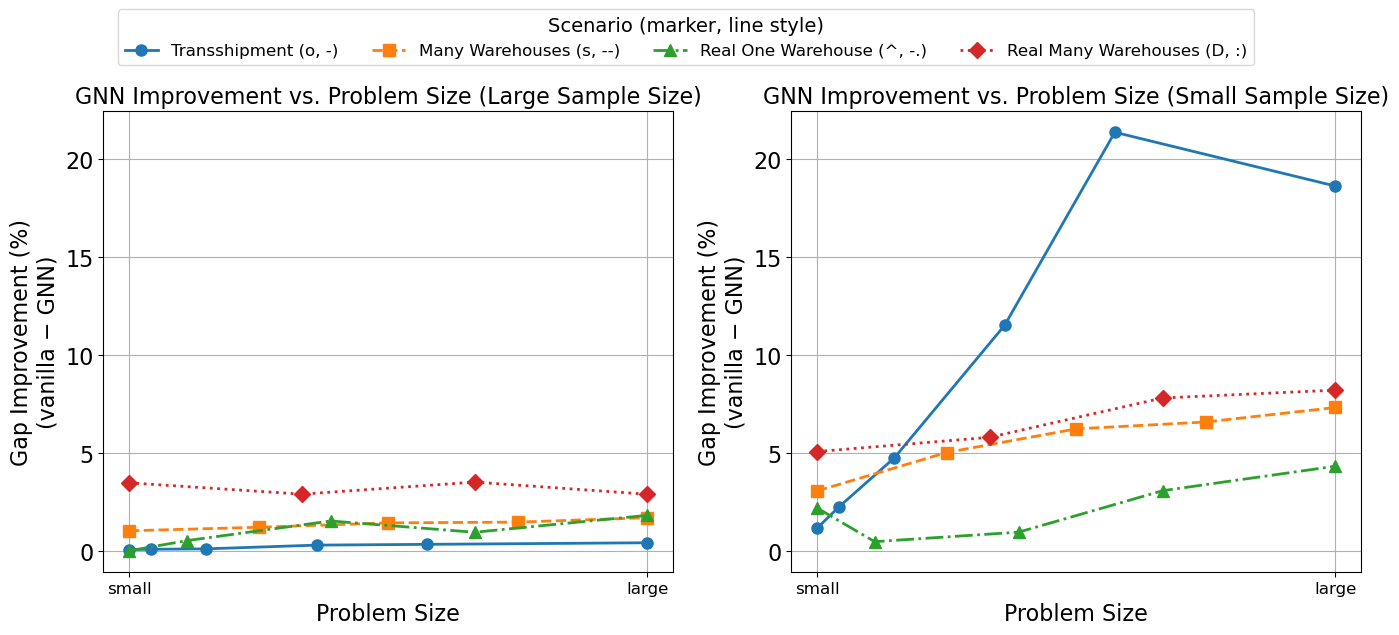

In [35]:
import matplotlib.pyplot as plt
import numpy as np

FONTSIZE = 16
plt.rcParams.update({'font.size': FONTSIZE})

scenario_data = {
    # "Serial System": serial_system_data,
    # "One Warehouse": one_warehouse_data,
    "Transshipment": transshipment_data,
    "Many Warehouses": many_warehouses_data,
    "Real One Warehouse": real_one_warehouse_data,
    "Real Many Warehouses": real_many_warehouses_data,
}

problem_size_fields = {
    # "Serial System": "system_length",
    # "One Warehouse": "n_stores",
    "Transshipment": "n_stores",
    "Many Warehouses": "n_stores",
    "Real One Warehouse": "n_stores",
    "Real Many Warehouses": "n_warehouses",
}
sample_size_fields = {
    "Serial System": "sample_size",
    # "One Warehouse": "sample_size",
    "Transshipment": "sample_size",
    "Many Warehouses": "sample_size",
    "Real One Warehouse": "sample_size",
    "Real Many Warehouses": "sample_size",
}

# Assign unique marker, line style, and color for each scenario
bw_markers = ['o', 's', '^', 'D', 'v', 'P', 'X']
bw_linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1))]
bw_colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
]
scenario_styles = {}
for i, name in enumerate(scenario_data.keys()):
    marker = bw_markers[i % len(bw_markers)]
    linestyle = bw_linestyles[i % len(bw_linestyles)]
    color = bw_colors[i % len(bw_colors)]
    scenario_styles[name] = {'marker': marker, 'linestyle': linestyle, 'color': color}

scenario_ps_values = {}
scenario_ss_values = {}
for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = sorted(set(r[ps_field] for r in results))
    ss_list = sorted(set(r[ss_field] for r in results))
    scenario_ps_values[name] = ps_list
    scenario_ss_values[name] = ss_list

impr_vs_ps_large = {}
impr_vs_ps_small = {}
norm_ps_ticks = {}
ps_tick_labels = {}

for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = scenario_ps_values[name]
    ss_list = scenario_ss_values[name]
    if len(ps_list) > 1:
        min_ps = min(ps_list)
        max_ps = max(ps_list)
        ps_range = max_ps - min_ps
        if ps_range == 0:
            x_ps = np.array([0.5 for _ in ps_list])
        else:
            x_ps = np.array([(ps - min_ps) / ps_range for ps in ps_list])
    else:
        x_ps = np.array([0.5])
    norm_ps_ticks[name] = x_ps
    ps_tick_labels[name] = [str(ps) for ps in ps_list]
    if not ss_list:
        continue
    large_sample_size = max(ss_list)
    small_sample_size = min(ss_list)
    ps_to_impr_large = {}
    for ps in ps_list:
        vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == large_sample_size]
        ps_to_impr_large[ps] = np.mean(vals) if vals else np.nan
    impr_vs_ps_large[name] = [ps_to_impr_large[ps] for ps in ps_list]
    ps_to_impr_small = {}
    for ps in ps_list:
        vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == small_sample_size]
        ps_to_impr_small[ps] = np.mean(vals) if vals else np.nan
    impr_vs_ps_small[name] = [ps_to_impr_small[ps] for ps in ps_list]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.4)

plot_handles = []
plot_labels = []
for name in scenario_data:
    if name not in impr_vs_ps_large or name not in impr_vs_ps_small:
        continue
    x_ps = norm_ps_ticks[name]
    y_ps_large = impr_vs_ps_large[name]
    y_ps_small = impr_vs_ps_small[name]
    style = scenario_styles[name]
    handle1, = ax1.plot(
        x_ps, y_ps_large,
        marker=style['marker'],
        linestyle=style['linestyle'],
        color=style['color'],
        label=name,
        markersize=8,
        linewidth=2
    )
    ax2.plot(
        x_ps, y_ps_small,
        marker=style['marker'],
        linestyle=style['linestyle'],
        color=style['color'],
        label=name,
        markersize=8,
        linewidth=2
    )
    plot_handles.append(handle1)
    plot_labels.append(
        f"{name} ({style['marker']}, {style['linestyle'] if isinstance(style['linestyle'], str) else 'custom'})"
    )

all_y_values = []
for y_list in impr_vs_ps_large.values():
    all_y_values.extend([y for y in y_list if not np.isnan(y)])
for y_list in impr_vs_ps_small.values():
    all_y_values.extend([y for y in y_list if not np.isnan(y)])
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    y_margin = 0.05 * (y_max - y_min) if y_max > y_min else 1
    y_lower = y_min - y_margin
    y_upper = y_max + y_margin
    ax1.set_ylim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)

for ax, title, sample_size_label in zip(
    [ax1, ax2],
    ['GNN Improvement vs. Problem Size (Large Sample Size)', 'GNN Improvement vs. Problem Size (Small Sample Size)'],
    ['large', 'small']
):
    ax.set_xlabel('Problem Size', fontsize=FONTSIZE)
    ax.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
    ax.set_title(title, fontsize=FONTSIZE)
    ax.grid(True)
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['small', 'large'], fontsize=FONTSIZE-4)

fig.legend(
    handles=plot_handles,
    labels=plot_labels,
    title='Scenario (marker, line style)',
    fontsize=FONTSIZE-4,
    title_fontsize=FONTSIZE-2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=len(plot_labels),
    frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

FONTSIZE = 16
plt.rcParams.update({'font.size': FONTSIZE})

def get_common_configs():
    color_scheme = {128: "#1f77b4", 1024: "#2ca02c", 8192: "#ff7f0e", 64: "#1f77b4", 288: "#ff7f0e"}
    marker_scheme = {128: "o", 1024: "v", 8192: "s", 64: "o", 288: "s"}
    linestyle_scheme = {"Vanilla NN": "-", "GNN": ":", "Data-Driven NN": "-"}
    return color_scheme, marker_scheme, linestyle_scheme

def make_legends(linestyle_scheme, color_scheme, marker_scheme):
    arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
                  for arch in linestyle_scheme.keys()]
    sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                                linestyle='none', label=f'{size}', markersize=8)
                     for size in color_scheme.keys()]
    return arch_lines, sample_patches

def setup_results_interpreter():
    results_interpretor = rri.RayResultsinterpreter()
    def custom_data_filler(out_row, reference_row): out_row['path'] = reference_row['path']
    def default_condition_setter(condition_name): return None
    return results_interpretor, custom_data_filler, default_condition_setter

# --- Data Parse Functions ---

def parse_serial_system():
    testset_name = "finals_serial"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
        "echelon_stock_hard": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard',
        "GNN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = ["serial_system_3", "serial_system_4", "serial_system_5", "serial_system_6", "serial_system_7"]
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path_fn in architectures.items():
        for config in configs:
            path = path_fn(config)
            system_length = int(config.split('_')[-1])
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'store_lead_time': [4],
                     'samples': [1],
                     'config': [config]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['config'] = config
                df['system_length'] = system_length
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    optimal_losses = {}
    for config in configs:
        system_length = int(config.split('_')[-1])
        optimal_data = df[(df['Architecture Class'] == 'echelon_stock_hard') & 
                          (df['train_dev_sample_and_batch_size'] == 8192) & 
                          (df['config'] == config)]
        if not optimal_data.empty:
            optimal_losses[system_length] = optimal_data['Test Loss'].min()
    stats_by_arch_sample_and_system_length = {}
    for system_length, optimal_loss in optimal_losses.items():
        system_data = df[df['system_length'] == system_length].copy()
        system_data = system_data[system_data['Architecture Class'] != 'echelon_stock_hard']
        if system_data.empty: continue
        system_data.loc[:, 'Gap %'] = ((system_data['Test Loss'] - optimal_loss) / optimal_loss) * 100
        for arch in system_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_system_length:
                    stats_by_arch_sample_and_system_length[key] = []
                sample_data = system_data[(system_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (system_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_system_length[key].append({
                        'system_length': system_length,
                        'mean_gap': mean_gap
                    })
    return {
        "stats": stats_by_arch_sample_and_system_length,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme
    }

def parse_one_warehouse():
    testset_name = "finals_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse',
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path_fn in architectures.items():
        for n_store in n_stores:
            path = path_fn(n_store)
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'store_lead_time': [[2, 6]],
                     'samples': [1],
                     'n_stores': [n_store]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['n_stores'] = n_store
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    stats_by_arch_sample_and_stores = {}
    for n_store in n_stores:
        store_data = df[df['n_stores'] == n_store].copy()
        if store_data.empty: continue
        best_test_loss = store_data['Test Loss'].min()
        store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
        for arch in store_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_stores:
                    stats_by_arch_sample_and_stores[key] = []
                sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (store_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_stores[key].append({
                        'n_stores': n_store,
                        'mean_gap': mean_gap
                    })
    return {
        "stats": stats_by_arch_sample_and_stores,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme
    }

def parse_transshipment():
    testset_name = "finals_transshipment"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment',
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    lower_bounds = {
        3: 8.533673716946652,
        5: 7.902133198919353,
        10: 8.296968310182638,
        20: 8.731082080524004,
        30: 8.37732777290095,
        50: 8.118102268777966,
    }
    dfs = []
    for arch_name, path_fn in architectures.items():
        for n_store in n_stores:
            path = path_fn(n_store)
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'store_lead_time': [4],
                     'samples': [1],
                     'n_stores': [n_store]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['n_stores'] = n_store
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    stats_by_arch_sample_and_stores = {}
    for n_store in n_stores:
        store_data = df[df['n_stores'] == n_store].copy()
        if store_data.empty: continue
        lower_bound = lower_bounds[n_store]
        store_data.loc[:, 'Optimality Gap %'] = ((store_data['Test Loss'] - lower_bound) / lower_bound) * 100
        for arch in store_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_stores:
                    stats_by_arch_sample_and_stores[key] = []
                sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (store_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Optimality Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_stores[key].append({
                        'n_stores': n_store,
                        'mean_gap': mean_gap
                    })
    return {
        "stats": stats_by_arch_sample_and_stores,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme
    }

def parse_real_one_warehouse():
    testset_name = "finals_real_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
        "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
    }
    store_counts = [3, 5, 10, 15, 21]
    sample_sizes = [64, 288]
    dfs = []
    jit_dfs = []
    for arch_name, path in architectures.items():
        for n_stores in store_counts:
            if arch_name == "Just-In-Time":
                for sample_size in sample_sizes:
                    jit_df = results_interpretor.make_table({1: path},
                        {'n_stores': [n_stores], 'train_dev_sample_and_batch_size': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if not jit_df.empty:
                        jit_df.insert(2, 'Architecture Class', arch_name)
                        jit_df.insert(1, 'hyperparam_name', arch_name)
                        jit_df['n_stores'] = n_stores
                        jit_df['train_dev_sample_and_batch_size'] = sample_size
                        jit_dfs.append(jit_df)
            else:
                for sample_size in sample_sizes:
                    df = results_interpretor.make_table({1: path},
                        {'train_dev_sample_and_batch_size': [sample_size],
                         'n_stores': [n_stores],
                         'test_n_samples': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if df.empty: continue
                    df.insert(2, 'Architecture Class', arch_name)
                    df.insert(1, 'hyperparam_name', arch_name)
                    df['train_dev_sample_and_batch_size'] = sample_size
                    df['n_stores'] = n_stores
                    dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()
    jit_losses = {}
    for n_stores in store_counts:
        for sample_size in sample_sizes:
            jit_data = jit_df[(jit_df['n_stores'] == n_stores) & 
                              (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
            if not jit_data.empty:
                jit_loss = jit_data['Test Loss'].min()
                jit_losses[(n_stores, sample_size)] = jit_loss
    stats_by_arch_sample_and_stores = {}
    for n_stores in store_counts:
        stores_data = df[df['n_stores'] == n_stores].copy()
        if stores_data.empty: continue
        for sample_size in sample_sizes:
            if (n_stores, sample_size) not in jit_losses: continue
            jit_loss = jit_losses[(n_stores, sample_size)]
            sample_data = stores_data[stores_data['train_dev_sample_and_batch_size'] == sample_size].copy()
            if sample_data.empty: continue
            sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
            for arch in sample_data['Architecture Class'].unique():
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_stores:
                    stats_by_arch_sample_and_stores[key] = []
                arch_data = sample_data[sample_data['Architecture Class'] == arch]
                if not arch_data.empty:
                    ratios = arch_data['Loss Ratio'].to_numpy()
                    mean_percentage = np.mean(ratios * 100)
                    stats_by_arch_sample_and_stores[key].append({
                        'n_stores': n_stores,
                        'mean_percentage': mean_percentage
                    })
    return {
        "stats": stats_by_arch_sample_and_stores,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme,
        "store_counts": store_counts
    }

def parse_many_warehouses():
    testset_name = "finals_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_warehouses',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = [
        "n_warehouse_10_2_lost_demand",
        "n_warehouse_20_3_lost_demand",
        "n_warehouse_30_4_lost_demand", 
        "n_warehouse_40_5_lost_demand", 
        "n_warehouse_50_6_lost_demand"
    ]
    config_to_stores_warehouses = {
        "n_warehouse_10_2_lost_demand": (10, 2),
        "n_warehouse_20_3_lost_demand": (20, 3),
        "n_warehouse_30_4_lost_demand": (30, 4),
        "n_warehouse_40_5_lost_demand": (40, 5),
        "n_warehouse_50_6_lost_demand": (50, 6)
    }
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path in architectures.items():
        for config in configs:
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'config': [config],
                     'samples': [1]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['config'] = config
                df['n_stores'] = config_to_stores_warehouses[config][0]
                df['n_warehouses'] = config_to_stores_warehouses[config][1]
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    best_losses = {}
    for config in configs:
        config_data = df[df['config'] == config]
        if not config_data.empty:
            best_losses[config] = config_data['Test Loss'].min()
    stats_by_arch_sample_and_config = {}
    for config in configs:
        if config not in best_losses: continue
        best_loss = best_losses[config]
        config_data = df[df['config'] == config].copy()
        if config_data.empty: continue
        config_data.loc[:, 'Gap %'] = ((config_data['Test Loss'] - best_loss) / best_loss) * 100
        for arch in config_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_config:
                    stats_by_arch_sample_and_config[key] = []
                sample_data = config_data[(config_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (config_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_config[key].append({
                        'config': config,
                        'n_stores': config_to_stores_warehouses[config][0],
                        'n_warehouses': config_to_stores_warehouses[config][1],
                        'mean_gap': mean_gap
                    })
    x_ticks = [10, 20, 30, 40, 50]
    x_tick_labels = []
    for n_stores in x_ticks:
        for config, (stores, warehouses) in config_to_stores_warehouses.items():
            if stores == n_stores:
                x_tick_labels.append(f"({stores},{warehouses})")
                break
    return {
        "stats": stats_by_arch_sample_and_config,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme,
        "x_ticks": x_ticks,
        "x_tick_labels": x_tick_labels
    }

def parse_real_many_warehouses():
    testset_name = "finals_real_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_n_warehouses_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
        "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
    }
    configs = [
        "n_warehouse_21_2_real_lost_demand",
        "n_warehouse_21_3_real_lost_demand",
        "n_warehouse_21_4_real_lost_demand",
        "n_warehouse_21_5_real_lost_demand"
    ]
    config_to_warehouses = {
        "n_warehouse_21_2_real_lost_demand": 2,
        "n_warehouse_21_3_real_lost_demand": 3,
        "n_warehouse_21_4_real_lost_demand": 4,
        "n_warehouse_21_5_real_lost_demand": 5
    }
    sample_sizes = [64, 288]
    dfs = []
    jit_dfs = []
    for arch_name, path in architectures.items():
        for config in configs:
            if arch_name == "Just-In-Time":
                for sample_size in sample_sizes:
                    jit_df = results_interpretor.make_table({1: path},
                        {'config': [config], 'train_dev_sample_and_batch_size': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if not jit_df.empty:
                        jit_df.insert(2, 'Architecture Class', arch_name)
                        jit_df.insert(1, 'hyperparam_name', arch_name)
                        jit_df['config'] = config
                        jit_df['n_warehouses'] = config_to_warehouses[config]
                        jit_df['train_dev_sample_and_batch_size'] = sample_size
                        jit_dfs.append(jit_df)
            else:
                for sample_size in sample_sizes:
                    df = results_interpretor.make_table({1: path},
                        {'train_dev_sample_and_batch_size': [sample_size],
                        'config': [config],
                        'test_n_samples': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if df.empty: continue
                    df.insert(2, 'Architecture Class', arch_name)
                    df.insert(1, 'hyperparam_name', arch_name)
                    df['train_dev_sample_and_batch_size'] = sample_size
                    df['config'] = config
                    df['n_warehouses'] = config_to_warehouses[config]
                    dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()
    jit_losses = {}
    for config in configs:
        for sample_size in sample_sizes:
            jit_data = jit_df[(jit_df['config'] == config) & 
                              (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
            if not jit_data.empty:
                jit_loss = jit_data['Test Loss'].min()
                jit_losses[(config, sample_size)] = jit_loss
    stats_by_arch_sample_and_config = {}
    for config in configs:
        config_data = df[df['config'] == config].copy()
        if config_data.empty: continue
        for sample_size in sample_sizes:
            if (config, sample_size) not in jit_losses: continue
            jit_loss = jit_losses[(config, sample_size)]
            sample_data = config_data[config_data['train_dev_sample_and_batch_size'] == sample_size].copy()
            if sample_data.empty: continue
            sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
            for arch in sample_data['Architecture Class'].unique():
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_config:
                    stats_by_arch_sample_and_config[key] = []
                arch_data = sample_data[sample_data['Architecture Class'] == arch]
                if not arch_data.empty:
                    ratios = arch_data['Loss Ratio'].to_numpy()
                    mean_percentage = np.mean(ratios * 100)
                    std_percentage = np.std(ratios * 100)
                    ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
                    stats_by_arch_sample_and_config[key].append({
                        'config': config,
                        'n_warehouses': config_to_warehouses[config],
                        'mean_percentage': mean_percentage,
                        'ci_lower': mean_percentage - ci_95,
                        'ci_upper': mean_percentage + ci_95
                    })
    x_ticks = sorted(list(config_to_warehouses.values()))
    return {
        "stats": stats_by_arch_sample_and_config,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme,
        "x_ticks": x_ticks
    }
# --- Data Loading ---
serial_system_data = parse_serial_system()
one_warehouse_data = parse_one_warehouse()
real_one_warehouse_data = parse_real_one_warehouse()
transshipment_data = parse_transshipment()
many_warehouses_data = parse_many_warehouses()
real_many_warehouses_data = parse_real_many_warehouses()

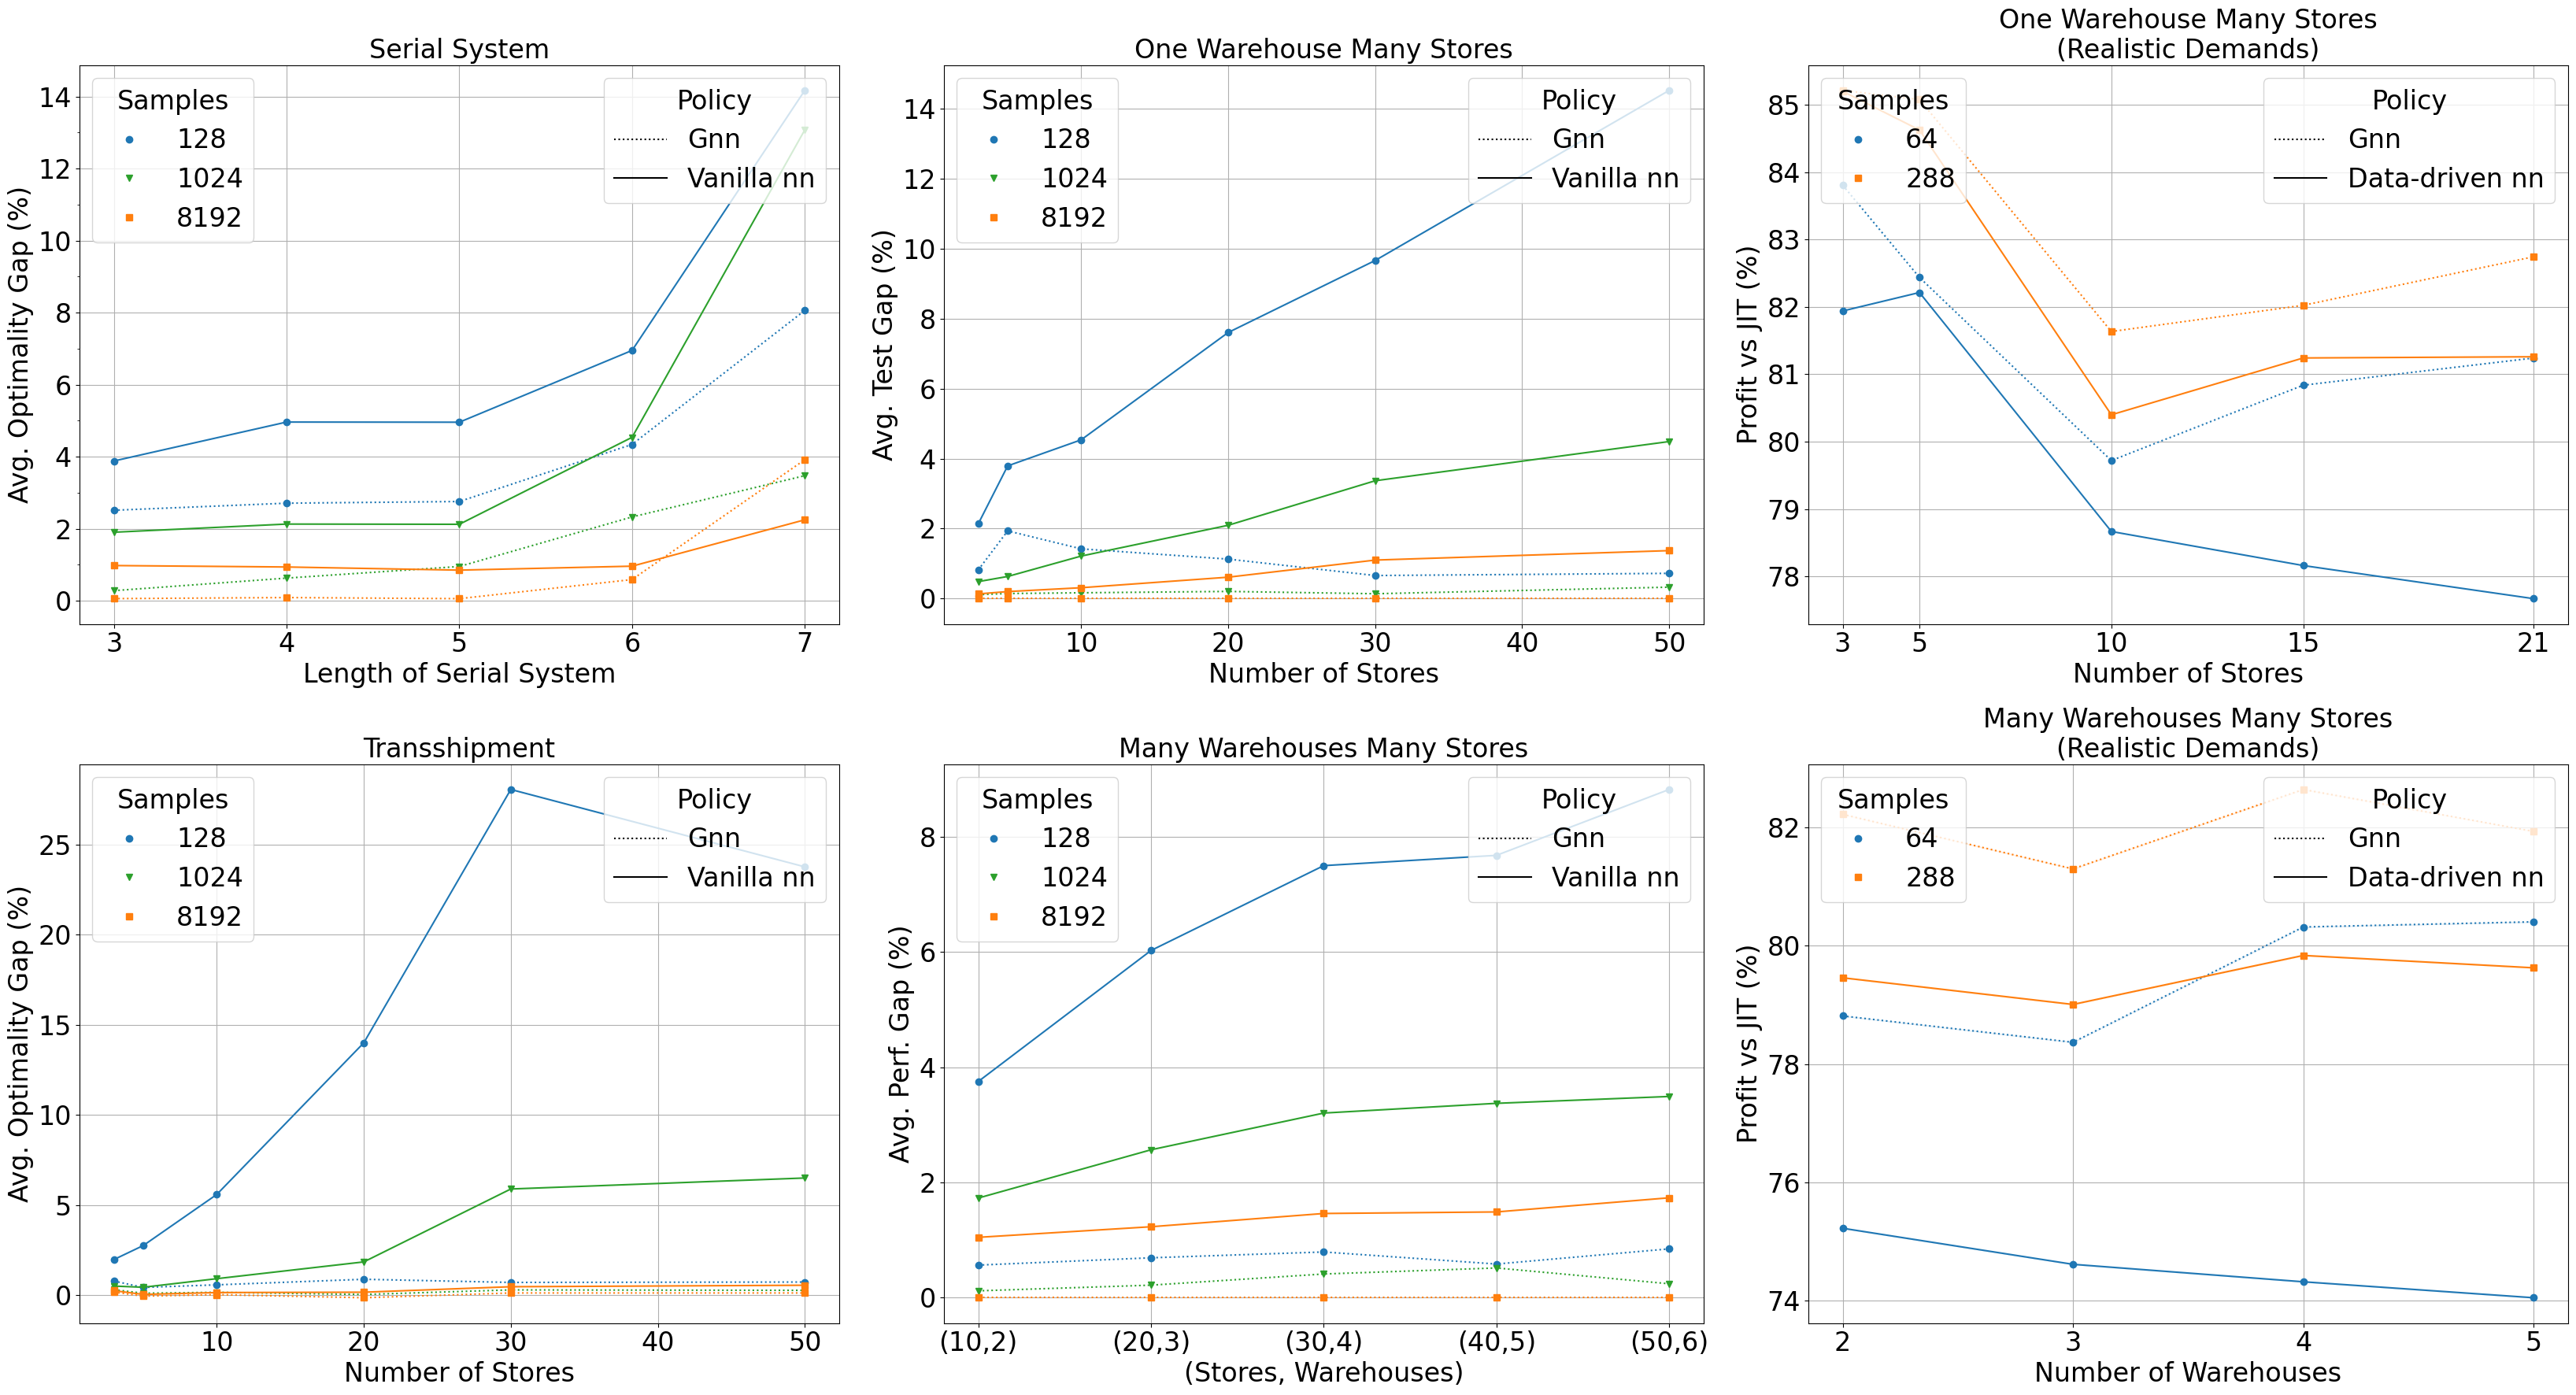

In [4]:

# --- Plot Functions ---

EXCLUDED_SAMPLE_SIZE = 0

# Define the preferred order for architectures
ARCH_ORDER = ["vanilla", "GNN"]

# Double the font size
FONTSIZE = 24  # <-- 2x larger than typical 12

def get_sorted_arches(stats):
    arches = set(arch for (arch, _) in stats.keys())
    ordered = [arch for arch in ARCH_ORDER if arch in arches]
    unordered = sorted([arch for arch in arches if arch not in ARCH_ORDER])
    return ordered + unordered

def get_sorted_samples(stats):
    samples = set(sample_size for (_, sample_size) in stats.keys() if sample_size != EXCLUDED_SAMPLE_SIZE)
    return sorted(samples)

def plot_serial_system(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    arch_lines = []
    sample_patches = []
    handled_arches = set()
    handled_samples = set()
    sorted_arches = get_sorted_arches(stats)
    sorted_samples = get_sorted_samples(stats)
    for arch in sorted_arches:
        for sample_size in sorted_samples:
            key = (arch, sample_size)
            if key not in stats:
                continue
            stats_list = stats[key]
            stats_df = pd.DataFrame(stats_list)
            if not stats_df.empty:
                system_length_array = stats_df['system_length'].to_numpy()
                mean_gap_array = stats_df['mean_gap'].to_numpy()
                ax.plot(system_length_array, mean_gap_array,
                        marker=marker_scheme[sample_size],
                        color=color_scheme[sample_size],
                        linestyle=linestyle_scheme.get(arch, "-"),
                        markersize=6)
                if arch not in handled_arches:
                    arch_lines.append(
                        mpl.lines.Line2D([], [], color='black', linestyle=linestyle_scheme.get(arch, "-"), label=arch.capitalize())
                    )
                    handled_arches.add(arch)
                if sample_size not in handled_samples:
                    sample_patches.append(
                        mpl.lines.Line2D([], [], color=color_scheme[sample_size], marker=marker_scheme[sample_size], linestyle='', markersize=6, label=str(sample_size))
                    )
                    handled_samples.add(sample_size)
    ax.set_xlabel('Length of Serial System', fontsize=FONTSIZE)
    ax.set_ylabel('Avg. Optimality Gap (%)', fontsize=FONTSIZE)
    ax.set_title('Serial System', fontsize=FONTSIZE)
    ax.grid(True)
    ax.set_xticks(range(3, 8))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=FONTSIZE-4)
    policy_legend = ax.legend(
        handles=arch_lines,
        loc='upper right',
        fontsize=FONTSIZE,
        title='Policy',
        title_fontsize=FONTSIZE
    )
    ax.add_artist(policy_legend)
    sample_legend = ax.legend(
        handles=sample_patches,
        loc='upper left',
        fontsize=FONTSIZE,
        title='Samples',
        title_fontsize=FONTSIZE
    )
    sample_legend.get_title().set_fontsize(FONTSIZE)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_one_warehouse(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    arch_lines = []
    sample_patches = []
    handled_arches = set()
    handled_samples = set()
    sorted_arches = get_sorted_arches(stats)
    sorted_samples = get_sorted_samples(stats)
    for arch in sorted_arches:
        for sample_size in sorted_samples:
            key = (arch, sample_size)
            if key not in stats:
                continue
            stats_list = stats[key]
            stats_df = pd.DataFrame(stats_list)
            if not stats_df.empty:
                n_stores_array = stats_df['n_stores'].to_numpy()
                mean_gap_array = stats_df['mean_gap'].to_numpy()
                ax.plot(n_stores_array, mean_gap_array,
                        marker=marker_scheme[sample_size],
                        color=color_scheme[sample_size],
                        linestyle=linestyle_scheme.get(arch, "-"),
                        markersize=6)
                if arch not in handled_arches:
                    arch_lines.append(
                        mpl.lines.Line2D([], [], color='black', linestyle=linestyle_scheme.get(arch, "-"), label=arch.capitalize())
                    )
                    handled_arches.add(arch)
                if sample_size not in handled_samples:
                    sample_patches.append(
                        mpl.lines.Line2D([], [], color=color_scheme[sample_size], marker=marker_scheme[sample_size], linestyle='', markersize=6, label=str(sample_size))
                    )
                    handled_samples.add(sample_size)
    ax.set_xlabel('Number of Stores', fontsize=FONTSIZE)
    ax.set_ylabel('Avg. Test Gap (%)', fontsize=FONTSIZE)
    ax.set_title('One Warehouse Many Stores', fontsize=FONTSIZE)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=FONTSIZE-4)
    policy_legend = ax.legend(
        handles=arch_lines,
        loc='upper right',
        fontsize=FONTSIZE,
        title='Policy',
        title_fontsize=FONTSIZE
    )
    ax.add_artist(policy_legend)
    sample_legend = ax.legend(
        handles=sample_patches,
        loc='upper left',
        fontsize=FONTSIZE,
        title='Samples',
        title_fontsize=FONTSIZE
    )
    sample_legend.get_title().set_fontsize(FONTSIZE)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_transshipment(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    arch_lines = []
    sample_patches = []
    handled_arches = set()
    handled_samples = set()
    sorted_arches = get_sorted_arches(stats)
    sorted_samples = get_sorted_samples(stats)
    for arch in sorted_arches:
        for sample_size in sorted_samples:
            key = (arch, sample_size)
            if key not in stats:
                continue
            stats_list = stats[key]
            stats_df = pd.DataFrame(stats_list)
            if not stats_df.empty:
                n_stores_array = stats_df['n_stores'].to_numpy()
                mean_gap_array = stats_df['mean_gap'].to_numpy()
                ax.plot(n_stores_array, mean_gap_array,
                        marker=marker_scheme[sample_size],
                        color=color_scheme[sample_size],
                        linestyle=linestyle_scheme.get(arch, "-"),
                        markersize=6)
                if arch not in handled_arches:
                    arch_lines.append(
                        mpl.lines.Line2D([], [], color='black', linestyle=linestyle_scheme.get(arch, "-"), label=arch.capitalize())
                    )
                    handled_arches.add(arch)
                if sample_size not in handled_samples:
                    sample_patches.append(
                        mpl.lines.Line2D([], [], color=color_scheme[sample_size], marker=marker_scheme[sample_size], linestyle='', markersize=6, label=str(sample_size))
                    )
                    handled_samples.add(sample_size)
    ax.set_xlabel('Number of Stores', fontsize=FONTSIZE)
    ax.set_ylabel('Avg. Optimality Gap (%)', fontsize=FONTSIZE)
    ax.set_title('Transshipment', fontsize=FONTSIZE)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=FONTSIZE-4)
    policy_legend = ax.legend(
        handles=arch_lines,
        loc='upper right',
        fontsize=FONTSIZE,
        title='Policy',
        title_fontsize=FONTSIZE
    )
    ax.add_artist(policy_legend)
    sample_legend = ax.legend(
        handles=sample_patches,
        loc='upper left',
        fontsize=FONTSIZE,
        title='Samples',
        title_fontsize=FONTSIZE
    )
    sample_legend.get_title().set_fontsize(FONTSIZE)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_real_one_warehouse(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    store_counts = data["store_counts"]
    arch_lines = []
    sample_patches = []
    handled_arches = set()
    handled_samples = set()
    sorted_arches = get_sorted_arches(stats)
    sorted_samples = get_sorted_samples(stats)
    for arch in sorted_arches:
        for sample_size in sorted_samples:
            key = (arch, sample_size)
            if key not in stats:
                continue
            stats_list = stats[key]
            stats_df = pd.DataFrame(stats_list)
            if not stats_df.empty:
                stats_df = stats_df.sort_values('n_stores')
                n_stores_array = stats_df['n_stores'].to_numpy()
                mean_percentage_array = stats_df['mean_percentage'].to_numpy()
                ax.plot(n_stores_array, mean_percentage_array,
                        marker=marker_scheme[sample_size],
                        color=color_scheme[sample_size],
                        linestyle=linestyle_scheme.get(arch, "-"),
                        markersize=6)
                if arch not in handled_arches:
                    arch_lines.append(
                        mpl.lines.Line2D([], [], color='black', linestyle=linestyle_scheme.get(arch, "-"), label=arch.capitalize())
                    )
                    handled_arches.add(arch)
                if sample_size not in handled_samples:
                    sample_patches.append(
                        mpl.lines.Line2D([], [], color=color_scheme[sample_size], marker=marker_scheme[sample_size], linestyle='', markersize=6, label=str(sample_size))
                    )
                    handled_samples.add(sample_size)
    ax.set_xlabel('Number of Stores', fontsize=FONTSIZE)
    ax.set_ylabel('Profit vs JIT (%)', fontsize=FONTSIZE)
    ax.set_title('One Warehouse Many Stores\n(Realistic Demands)', fontsize=FONTSIZE)
    ax.grid(True)
    ax.set_xticks(store_counts)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=FONTSIZE-4)
    policy_legend = ax.legend(
        handles=arch_lines,
        loc='upper right',
        fontsize=FONTSIZE,
        title='Policy',
        title_fontsize=FONTSIZE
    )
    ax.add_artist(policy_legend)
    sample_legend = ax.legend(
        handles=sample_patches,
        loc='upper left',
        fontsize=FONTSIZE,
        title='Samples',
        title_fontsize=FONTSIZE
    )
    sample_legend.get_title().set_fontsize(FONTSIZE)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_many_warehouses(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    x_ticks = data["x_ticks"]
    x_tick_labels = data["x_tick_labels"]
    arch_lines = []
    sample_patches = []
    handled_arches = set()
    handled_samples = set()
    sorted_arches = get_sorted_arches(stats)
    sorted_samples = get_sorted_samples(stats)
    for arch in sorted_arches:
        for sample_size in sorted_samples:
            key = (arch, sample_size)
            if key not in stats:
                continue
            stats_list = stats[key]
            stats_df = pd.DataFrame(stats_list)
            if not stats_df.empty:
                stats_df = stats_df.sort_values('n_stores')
                n_stores_array = stats_df['n_stores'].to_numpy()
                mean_gap_array = stats_df['mean_gap'].to_numpy()
                ax.plot(n_stores_array, mean_gap_array,
                        marker=marker_scheme[sample_size],
                        color=color_scheme[sample_size],
                        linestyle=linestyle_scheme.get(arch, "-"),
                        markersize=6)
                if arch not in handled_arches:
                    arch_lines.append(
                        mpl.lines.Line2D([], [], color='black', linestyle=linestyle_scheme.get(arch, "-"), label=arch.capitalize())
                    )
                    handled_arches.add(arch)
                if sample_size not in handled_samples:
                    sample_patches.append(
                        mpl.lines.Line2D([], [], color=color_scheme[sample_size], marker=marker_scheme[sample_size], linestyle='', markersize=6, label=str(sample_size))
                    )
                    handled_samples.add(sample_size)
    ax.set_xlabel('(Stores, Warehouses)', fontsize=FONTSIZE)
    ax.set_ylabel('Avg. Perf. Gap (%)', fontsize=FONTSIZE)
    ax.set_title('Many Warehouses Many Stores', fontsize=FONTSIZE)
    ax.grid(True)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=FONTSIZE-4)
    policy_legend = ax.legend(
        handles=arch_lines,
        loc='upper right',
        fontsize=FONTSIZE,
        title='Policy',
        title_fontsize=FONTSIZE
    )
    ax.add_artist(policy_legend)
    sample_legend = ax.legend(
        handles=sample_patches,
        loc='upper left',
        fontsize=FONTSIZE,
        title='Samples',
        title_fontsize=FONTSIZE
    )
    sample_legend.get_title().set_fontsize(FONTSIZE)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_real_many_warehouses(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    x_ticks = data["x_ticks"]
    arch_lines = []
    sample_patches = []
    handled_arches = set()
    handled_samples = set()
    sorted_arches = get_sorted_arches(stats)
    sorted_samples = get_sorted_samples(stats)
    for arch in sorted_arches:
        for sample_size in sorted_samples:
            key = (arch, sample_size)
            if key not in stats:
                continue
            stats_list = stats[key]
            stats_df = pd.DataFrame(stats_list)
            if not stats_df.empty:
                stats_df = stats_df.sort_values('n_warehouses')
                n_warehouses_array = stats_df['n_warehouses'].to_numpy()
                mean_percentage_array = stats_df['mean_percentage'].to_numpy()
                ci_lower_array = stats_df['ci_lower'].to_numpy()
                ci_upper_array = stats_df['ci_upper'].to_numpy()
                ax.plot(n_warehouses_array, mean_percentage_array,
                        marker=marker_scheme[sample_size],
                        color=color_scheme[sample_size],
                        linestyle=linestyle_scheme.get(arch, "-"),
                        markersize=6)
                ax.fill_between(n_warehouses_array,
                                ci_lower_array,
                                ci_upper_array,
                                color=color_scheme[sample_size],
                                alpha=0.1)
                if arch not in handled_arches:
                    arch_lines.append(
                        mpl.lines.Line2D([], [], color='black', linestyle=linestyle_scheme.get(arch, "-"), label=arch.capitalize())
                    )
                    handled_arches.add(arch)
                if sample_size not in handled_samples:
                    sample_patches.append(
                        mpl.lines.Line2D([], [], color=color_scheme[sample_size], marker=marker_scheme[sample_size], linestyle='', markersize=6, label=str(sample_size))
                    )
                    handled_samples.add(sample_size)
    ax.set_xlabel('Number of Warehouses', fontsize=FONTSIZE)
    ax.set_ylabel('Profit vs JIT (%)', fontsize=FONTSIZE)
    ax.set_title('Many Warehouses Many Stores\n(Realistic Demands)', fontsize=FONTSIZE)
    ax.grid(True)
    ax.set_xticks(x_ticks)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=FONTSIZE-4)
    policy_legend = ax.legend(
        handles=arch_lines,
        loc='upper right',
        fontsize=FONTSIZE,
        title='Policy',
        title_fontsize=FONTSIZE
    )
    ax.add_artist(policy_legend)
    sample_legend = ax.legend(
        handles=sample_patches,
        loc='upper left',
        fontsize=FONTSIZE,
        title='Samples',
        title_fontsize=FONTSIZE
    )
    sample_legend.get_title().set_fontsize(FONTSIZE)
    return linestyle_scheme, color_scheme, marker_scheme

# --- Plotting Section ---
fig, axes = plt.subplots(2, 3, figsize=(33, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.35)

plot_serial_system(axes[0, 0], serial_system_data)
plot_one_warehouse(axes[0, 1], one_warehouse_data)
plot_real_one_warehouse(axes[0, 2], real_one_warehouse_data)
plot_transshipment(axes[1, 0], transshipment_data)
plot_many_warehouses(axes[1, 1], many_warehouses_data)
plot_real_many_warehouses(axes[1, 2], real_many_warehouses_data)

plt.tight_layout()
plt.show()

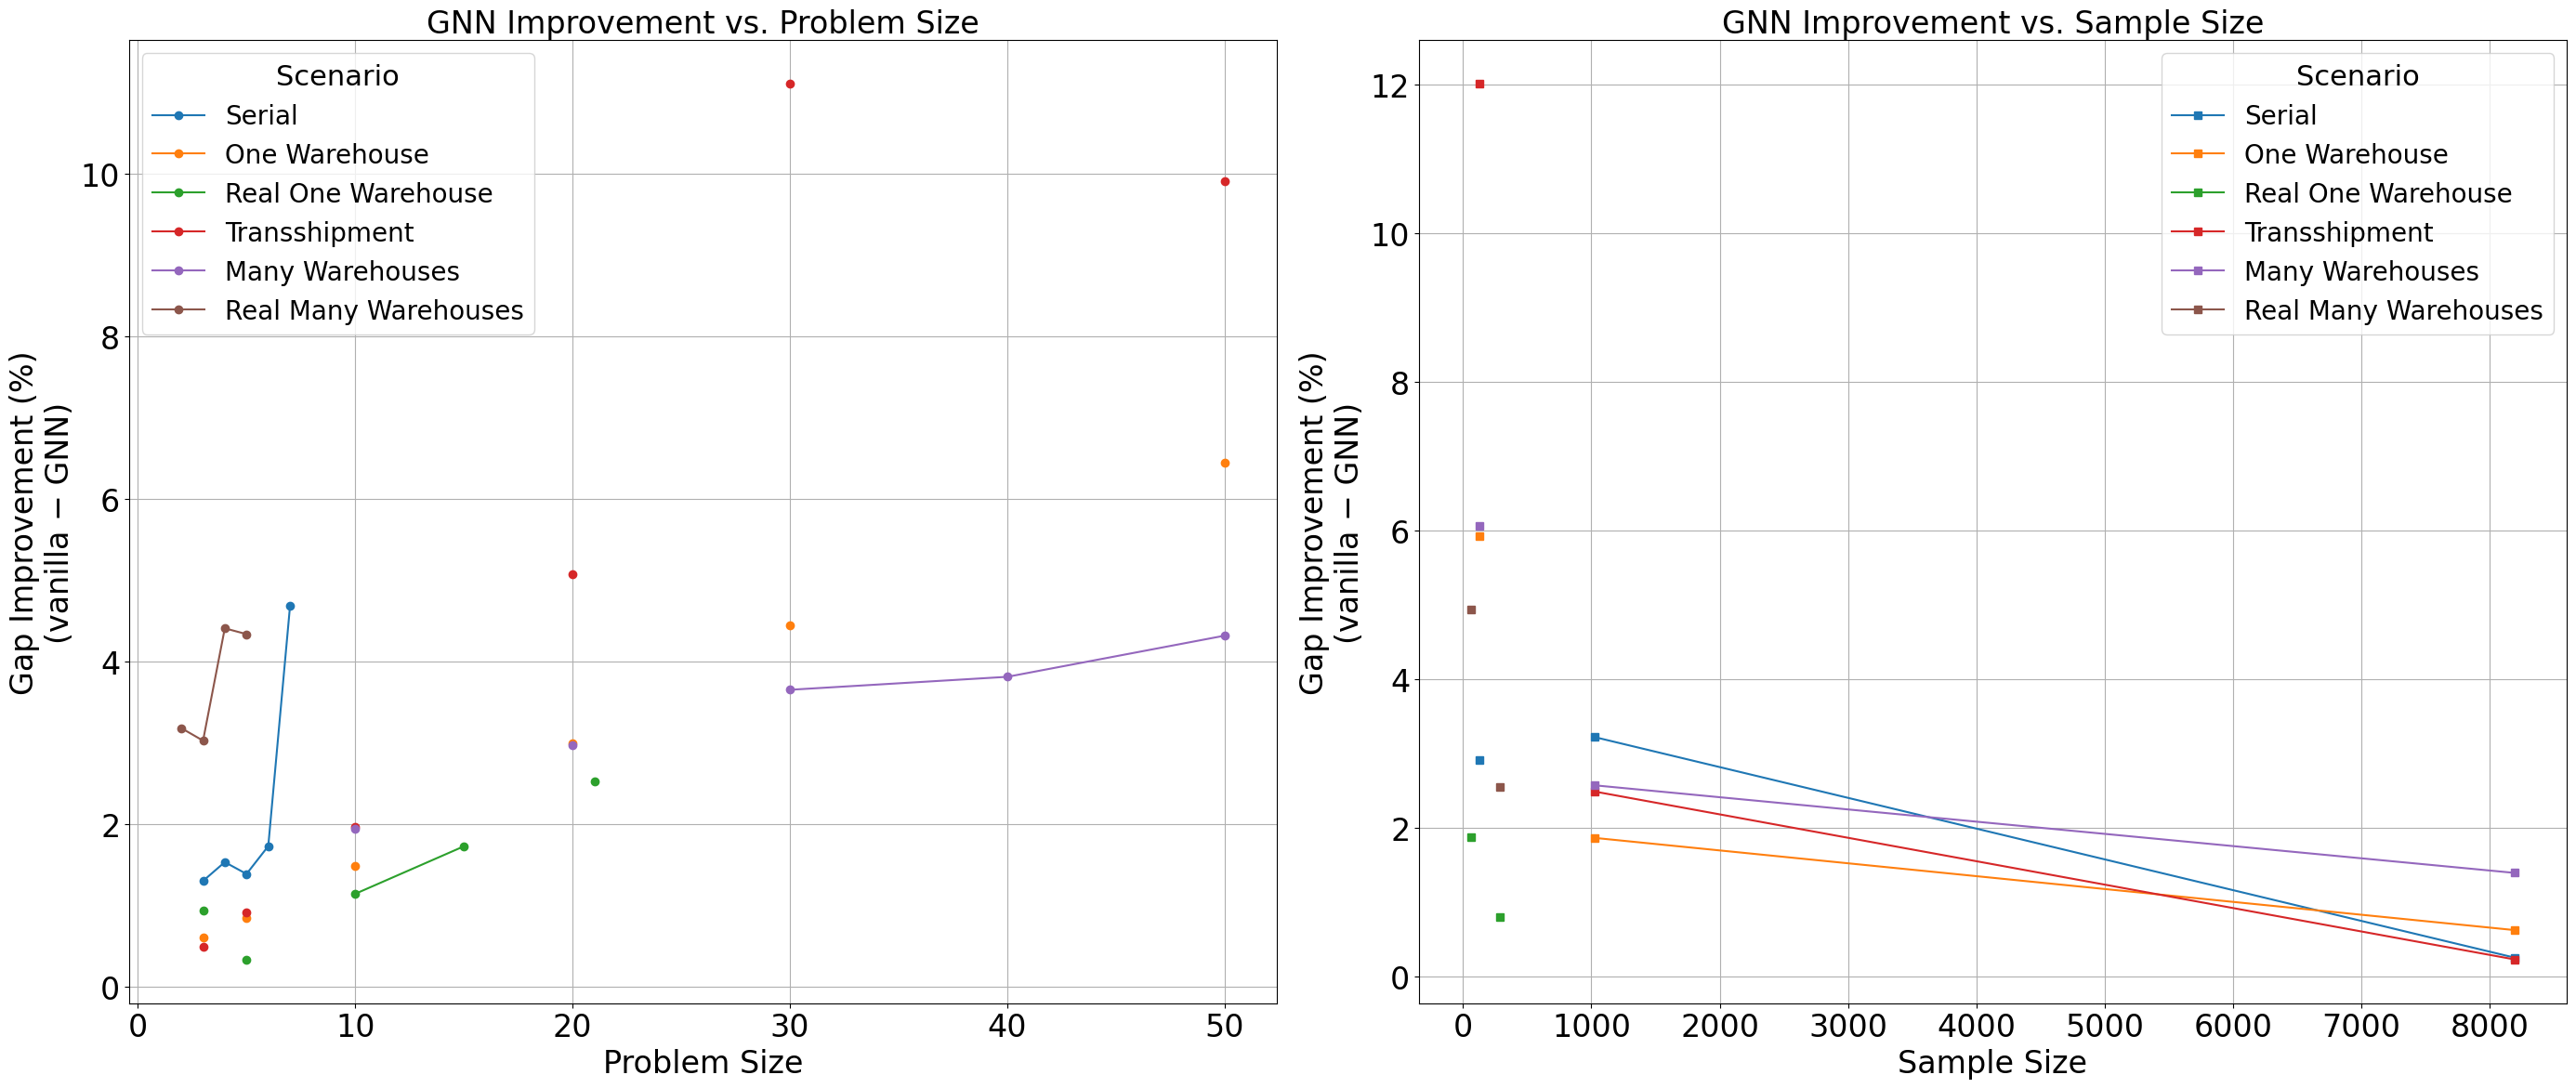

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

FONTSIZE = 24

scenarios = {
    "Serial": (serial_system_data,       "system_length"),
    "One Warehouse": (one_warehouse_data, "n_stores"),
    "Real One Warehouse": (real_one_warehouse_data, "n_stores"),
    "Transshipment": (transshipment_data, "n_stores"),
    "Many Warehouses": (many_warehouses_data, "n_stores"),
    "Real Many Warehouses": (real_many_warehouses_data, "n_warehouses"),
}

real_scenarios = {"Real One Warehouse", "Real Many Warehouses"}

all_sample_sizes  = sorted({ s for data, _ in scenarios.values() for (_, s) in data["stats"].keys() })
all_problem_sizes = sorted({
    entry[field]
    for _, (data, field) in scenarios.items()
    for lst in data["stats"].values()
    for entry in lst
})

impr_vs_ps = {name: [] for name in scenarios}
for name, (data, field) in scenarios.items():
    stats = data["stats"]
    for ps in all_problem_sizes:
        diffs = []
        for s in all_sample_sizes:
            v = [e["mean_gap"] for e in stats.get(("Vanilla NN", s), []) if e[field] == ps]
            if not v:
                v = [(e["mean_gap"] if "mean_gap" in e else e["mean_percentage"]) for e in stats.get(("Data-Driven NN", s), []) if e[field] == ps]
            g = [ (e["mean_gap"] if "mean_gap" in e else e["mean_percentage"]) for e in stats.get(("GNN",     s), []) if e[field] == ps ]
            if v and g:
                if name in real_scenarios:
                    diffs.append(-(np.mean(v) - np.mean(g)))
                else:
                    diffs.append(np.mean(v) - np.mean(g))
        impr_vs_ps[name].append(np.mean(diffs) if diffs else np.nan)

impr_vs_ss = {name: [] for name in scenarios}
for name, (data, field) in scenarios.items():
    stats = data["stats"]
    for s in all_sample_sizes:
        diffs = []
        for ps in all_problem_sizes:
            v = [e["mean_gap"] for e in stats.get(("Vanilla NN", s), []) if e[field] == ps]
            if not v:
                v = [(e["mean_gap"] if "mean_gap" in e else e["mean_percentage"])  for e in stats.get(("Data-Driven NN", s), []) if e[field] == ps]
            g = [ (e["mean_gap"] if "mean_gap" in e else e["mean_percentage"]) for e in stats.get(("GNN",     s), []) if e[field] == ps ]
            if v and g:
                if name in real_scenarios:
                    diffs.append(-(np.mean(v) - np.mean(g)))
                else:
                    diffs.append(np.mean(v) - np.mean(g))
        impr_vs_ss[name].append(np.mean(diffs) if diffs else np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))
plt.subplots_adjust(wspace=0.4)

for name in scenarios:
    ax1.plot(all_problem_sizes, impr_vs_ps[name], marker='o', label=name)
    ax2.plot(all_sample_sizes,   impr_vs_ss[name], marker='s', label=name)

ax1.set_xlabel('Problem Size', fontsize=FONTSIZE)
ax1.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax1.set_title('GNN Improvement vs. Problem Size', fontsize=FONTSIZE)
ax1.grid(True)
ax1.tick_params(labelsize=FONTSIZE)
ax1.legend(title='Scenario', fontsize=FONTSIZE-4, title_fontsize=FONTSIZE-2)

ax2.set_xlabel('Sample Size', fontsize=FONTSIZE)
ax2.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax2.set_title('GNN Improvement vs. Sample Size', fontsize=FONTSIZE)
ax2.grid(True)
ax2.tick_params(labelsize=FONTSIZE)
ax2.legend(title='Scenario', fontsize=FONTSIZE-4, title_fontsize=FONTSIZE-2)

plt.tight_layout()
plt.show()


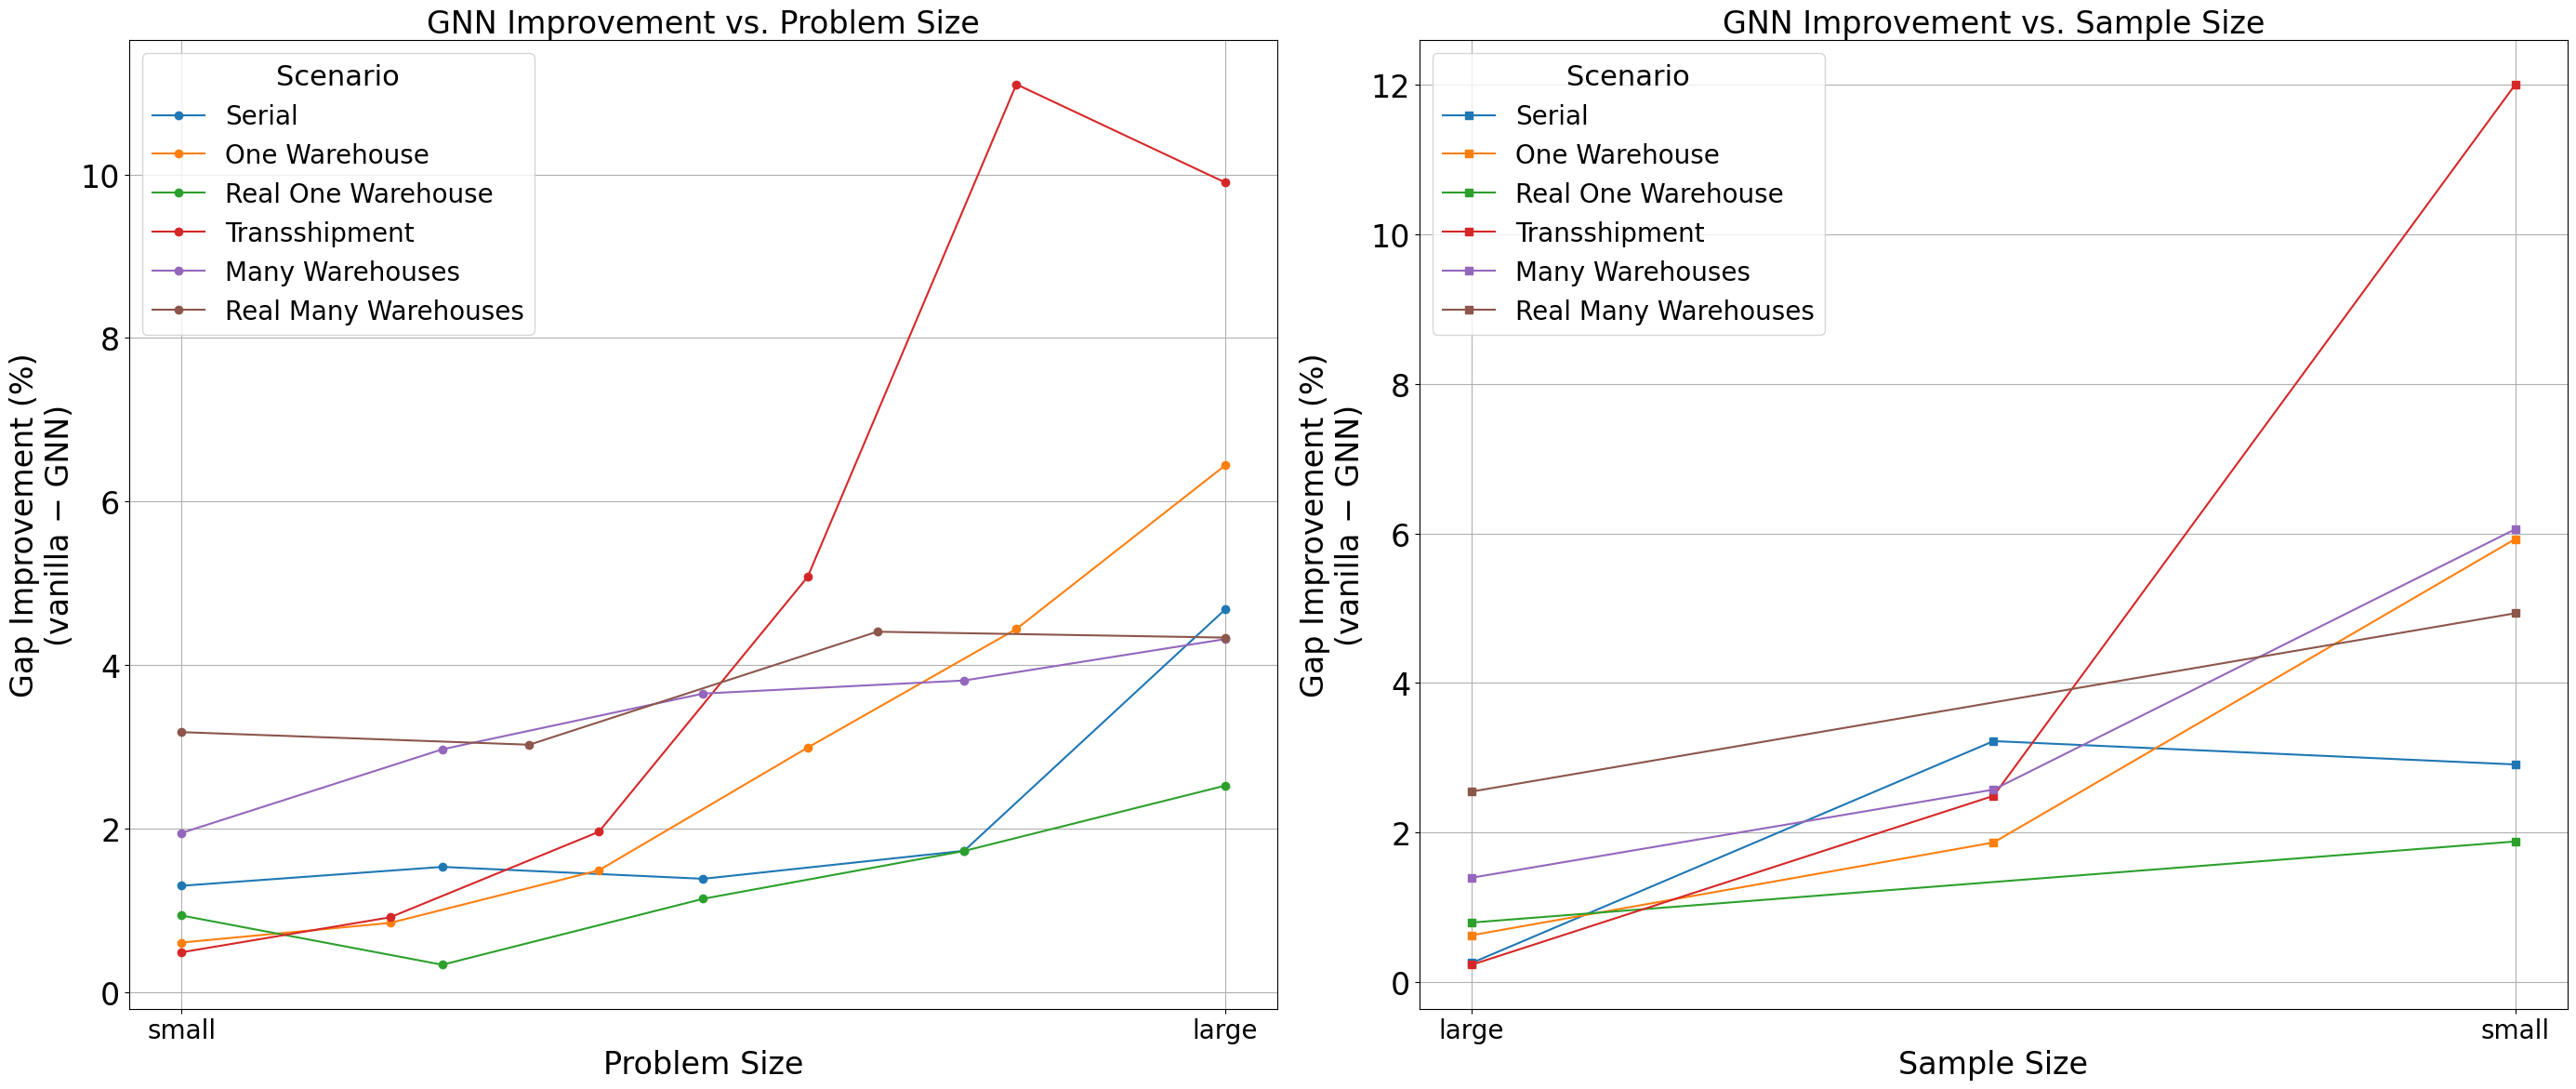

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# … (your data + computations for impr_vs_ps & impr_vs_ss) …

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))
plt.subplots_adjust(wspace=0.4)

for name, (data, field) in scenarios.items():
    # 1) per‐scenario problem sizes
    ps_list = sorted({
        entry[field]
        for lst in data["stats"].values()
        for entry in lst
    })
    # 2) per‐scenario sample sizes
    ss_list = sorted({
        s
        for (model, s), lst in data["stats"].items()
        if lst  # only keep s if there's at least one entry
    })

    # 3) build normalized x’s
    x_ps = np.linspace(0, 1, len(ps_list))
    x_ss = np.linspace(1, 0, len(ss_list))  # reversed

    # 4) extract the y’s in that order
    y_ps = [impr_vs_ps[name][all_problem_sizes.index(ps)] for ps in ps_list]
    y_ss = [impr_vs_ss[name][all_sample_sizes.index(s)]    for s  in ss_list]

    ax1.plot(x_ps, y_ps, marker='o', label=name)
    ax2.plot(x_ss, y_ss, marker='s', label=name)

# Problem‐size: small→large
ax1.set_xlabel('Problem Size', fontsize=FONTSIZE)
ax1.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax1.set_title('GNN Improvement vs. Problem Size', fontsize=FONTSIZE)
ax1.grid(True)
ax1.tick_params(labelsize=FONTSIZE)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['small', 'large'], fontsize=FONTSIZE-4)
ax1.legend(title='Scenario', fontsize=FONTSIZE-4, title_fontsize=FONTSIZE-2)

# Sample‐size: large→small
ax2.set_xlabel('Sample Size', fontsize=FONTSIZE)
ax2.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax2.set_title('GNN Improvement vs. Sample Size', fontsize=FONTSIZE)
ax2.grid(True)
ax2.tick_params(labelsize=FONTSIZE)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['large', 'small'], fontsize=FONTSIZE-4)
ax2.legend(title='Scenario', fontsize=FONTSIZE-4, title_fontsize=FONTSIZE-2)

plt.tight_layout()
plt.show()


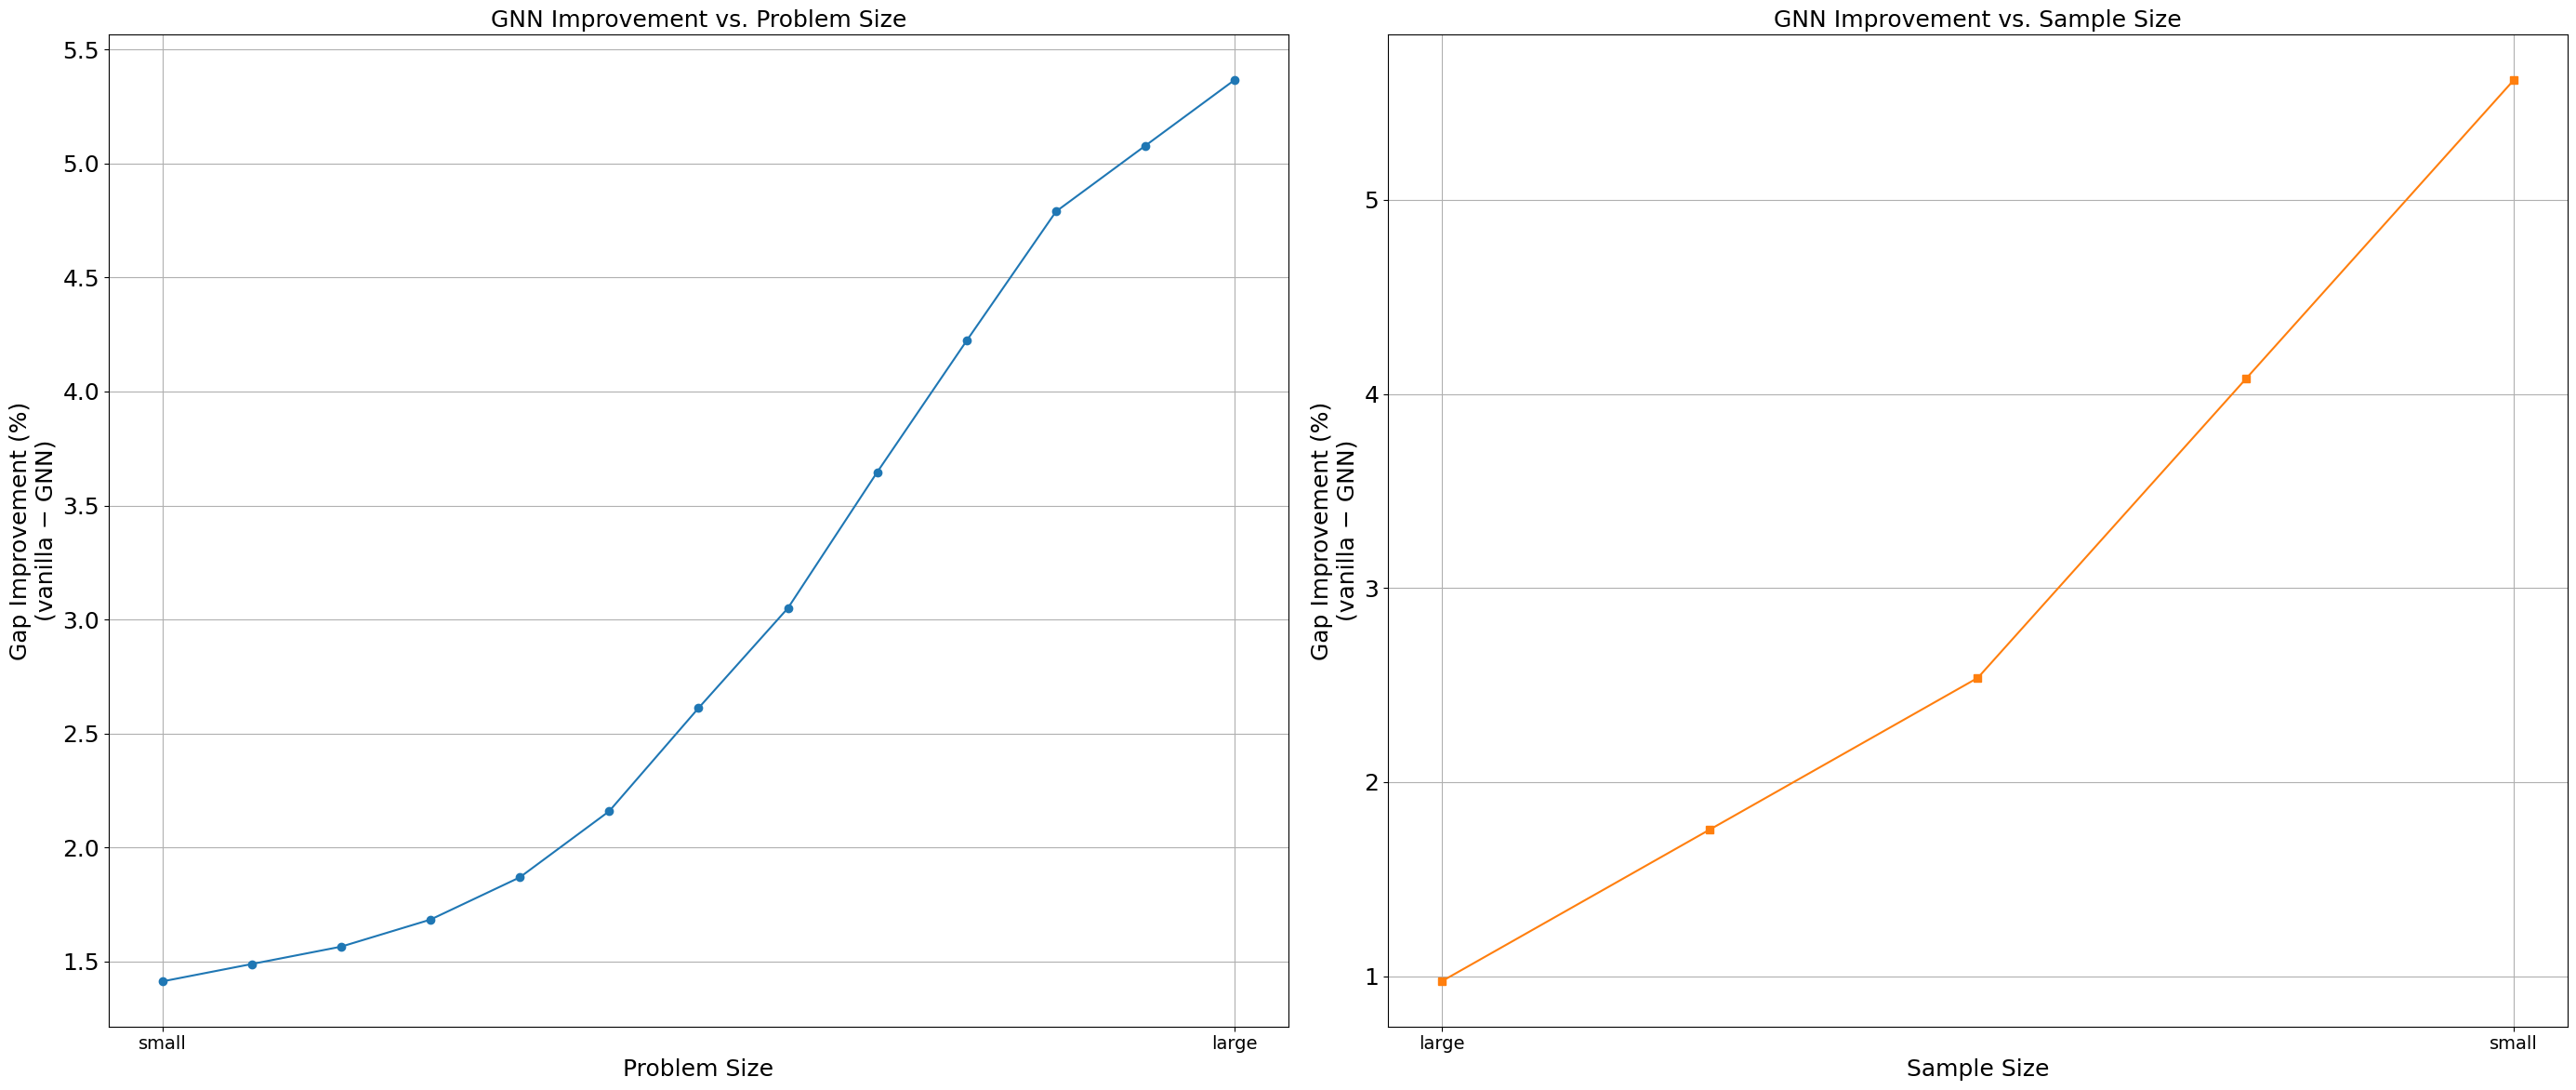

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# … (your data + computations for impr_vs_ps & impr_vs_ss) …

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))
plt.subplots_adjust(wspace=0.4)

# Gather all unique problem sizes and sample sizes across all scenarios
all_ps_set = set()
all_ss_set = set()
for _, (data, field) in scenarios.items():
    all_ps_set.update(entry[field] for lst in data["stats"].values() for entry in lst)
    all_ss_set.update(s for (model, s), lst in data["stats"].items() if lst)
all_ps_list = sorted(all_ps_set)
all_ss_list = sorted(all_ss_set, reverse=True)  # largest to smallest for sample size

# Normalized x for problem size (small to large) and sample size (large to small)
x_ps = np.linspace(0, 1, len(all_ps_list))
x_ss = np.linspace(0, 1, len(all_ss_list))  # 0=large, 1=small

# For each scenario, collect y values at all_ps_list and all_ss_list, interpolating if needed
all_y_ps = []
all_y_ss = []
for name, (data, field) in scenarios.items():
    # Problem size
    ps_list = sorted({entry[field] for lst in data["stats"].values() for entry in lst})
    y_ps = [impr_vs_ps[name][all_problem_sizes.index(ps)] for ps in ps_list]
    x_ps_scen = np.linspace(0, 1, len(ps_list))
    interp_y_ps = np.interp(x_ps, x_ps_scen, y_ps)
    all_y_ps.append(interp_y_ps)
    # Sample size
    ss_list = sorted({s for (model, s), lst in data["stats"].items() if lst}, reverse=True)
    y_ss = [impr_vs_ss[name][all_sample_sizes.index(s)] for s in ss_list]
    x_ss_scen = np.linspace(0, 1, len(ss_list))
    interp_y_ss = np.interp(x_ss, x_ss_scen, y_ss)
    all_y_ss.append(interp_y_ss)

# Average across scenarios
avg_y_ps = np.mean(all_y_ps, axis=0)
avg_y_ss = np.mean(all_y_ss, axis=0)

ax1.plot(x_ps, avg_y_ps, marker='o', color='C0')
ax2.plot(x_ss, avg_y_ss, marker='s', color='C1')

ax1.set_xlabel('Problem Size', fontsize=FONTSIZE)
ax1.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax1.set_title('GNN Improvement vs. Problem Size', fontsize=FONTSIZE)
ax1.grid(True)
ax1.tick_params(labelsize=FONTSIZE)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['small', 'large'], fontsize=FONTSIZE-4)

ax2.set_xlabel('Sample Size', fontsize=FONTSIZE)
ax2.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax2.set_title('GNN Improvement vs. Sample Size', fontsize=FONTSIZE)
ax2.grid(True)
ax2.tick_params(labelsize=FONTSIZE)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['large', 'small'], fontsize=FONTSIZE-4)

plt.tight_layout()
plt.show()
